# A short but intense dive into model error concepts

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 15
import flopy
import pyemu
import prep_deps

### A simple cross section model

We will use a 10-cell very simple cross section model to demonstrate some interesting concepts related to model error.  This model has a constant head on the left and a specified inflow on the right.  There are two stress periods (both steady state).  The first stress period is considered "historic" and the second is considered "forecast" - the inflow on the right side increases in the forecast period

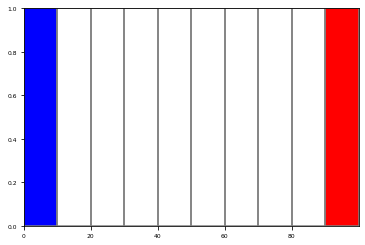

In [2]:
t_d = "template_xsec"
nam_file = "10par_xsec.nam"
m = flopy.modflow.Modflow.load(nam_file,model_ws=t_d)
mm = flopy.plot.PlotCrossSection(model=m,line={"row":0})
mm.plot_grid()
mm.plot_bc("wel")
mm.plot_ibound()

Load the pest control file and plot the 'truth' observations - the outputs from the truth model

In [3]:
prep_deps.prep_template(t_d)
pst = pyemu.Pst(os.path.join(t_d,"pest.pst"))

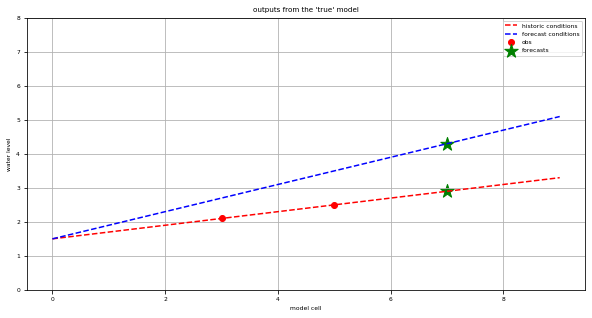

In [4]:
fig,ax = plt.subplots(1,1,figsize=(10,5))
obs = pst.observation_data
ax.plot(obs.obsval[:10].values,"r--",label="historic conditions")
ax.plot(obs.obsval[10:].values,'b--',label="forecast conditions")
obs_idx = [3,5]
ax.scatter(obs_idx,obs.obsval.iloc[obs_idx].values,marker='o',c='r',label="obs")
ax.scatter([7,7],obs.obsval.iloc[[7,17]].values,marker="*",s=200,c='g',label="forecasts")
ax.grid()
ax.legend()
ax.set_ylabel("water level")
ax.set_xlabel("model cell")
ax.set_ylim(0,8)
t = ax.set_title("outputs from the 'true' model")

### Introducing model error

To simulate model error, we will introduce a difference between the truth model and the model we will be using for history matching and uncertainty analysis - this is model error in the conceptual sense.  What we will do is lower the stage of the left hand boundary from 1.5 in the truth to 1.0 in the model we will use.  

To be clear, the observations and "true" forecast values were generated with the model that has boundary stage of 1.5 and a uniform HK of 2.5 - this model serves as the "truth" or model of reality. In practice, we will never know the "true" value of the forecasts - that's why we are modeling! 

Now let's see what happens when we try to assimilate those two head observations through history matching 

In [5]:
pst = pyemu.Pst(os.path.join(t_d,"pest.pst"))

In [6]:
pst.parameter_data

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom,extra
parnme,,,,,,,,,,,
stage,stage,fixed,factor,1.0,0.10,3.0,k,1.0,0.0,1,NaN
k_01,k_01,log,factor,2.5,0.25,25.0,k,1.0,0.0,1,NaN
k_02,k_02,log,factor,2.5,0.25,25.0,k,1.0,0.0,1,NaN
k_03,k_03,log,factor,2.5,0.25,25.0,k,1.0,0.0,1,NaN
k_04,k_04,log,factor,2.5,0.25,25.0,k,1.0,0.0,1,NaN
k_05,k_05,log,factor,2.5,0.25,25.0,k,1.0,0.0,1,NaN
k_06,k_06,log,factor,2.5,0.25,25.0,k,1.0,0.0,1,NaN
k_07,k_07,log,factor,2.5,0.25,25.0,k,1.0,0.0,1,NaN
k_08,k_08,log,factor,2.5,0.25,25.0,k,1.0,0.0,1,NaN


See the `stage` parameter with the "fixed" transform and a value of 1.0? 

In [7]:
pst.observation_data

,obsnme,obsval,weight,obgnme,extra
obsnme,,,,,
h01_01,h01_01,1.5,0.0,head,NaN
h01_02,h01_02,1.7,0.0,head,NaN
h01_03,h01_03,1.9,0.0,head,NaN
h01_04,h01_04,2.1,10.0,head,NaN
h01_05,h01_05,2.3,0.0,head,NaN
h01_06,h01_06,2.5,10.0,head,NaN
h01_07,h01_07,2.7,0.0,head,NaN
h01_08,h01_08,2.9,0.0,head,NaN
h01_09,h01_09,3.1,0.0,head,NaN


We are monitoring the simulated water levels in all model cells from both stress periods.  The `obsval` values are the outputs from the "truth" model without any noise.

First let calculate the initial residuals by running the model one time

In [8]:
pst.control_data.noptmax = 0
pst.write(os.path.join(t_d,"pest.pst"))
pyemu.os_utils.run("pestpp-glm pest.pst",cwd=t_d)
pst = pyemu.Pst(os.path.join(t_d,"pest.pst"))
init_res = pst.res.copy()
pst.phi

noptmax:0, npar_adj:10, nnz_obs:2


50.0

Ok, so the initial phi is 50.  Remember we are using the true or correct HK values in all cells and we dont have any noise added to the observations.  Let's look at the residuals at the two observation locations:

In [9]:
pst.res.loc[pst.nnz_obs_names,:]

,name,group,measured,modelled,residual,weight
name,,,,,,
h01_04,h01_04,head,2.1,1.6,0.5,10.0
h01_06,h01_06,head,2.5,2.0,0.5,10.0


As expected, the model is under-simulating the water levels compared to the truth.  Conceptually, the difference between the observations from the truth model and the simulated outputs from model with error is called "structural noise" - noise that is arising from the incorrect structure of the model.  In practice, it is not always so clear what is "signal" and what is noise.  Signal is the information in the observations that we can (appropriately) use in data assimilation to learn about the parameters, that is, reduce parameter uncertainty.  The problem with structural noise, just like any other noise, is that it is mixed in with the signal.  So just like we can "overfit" to measurement noise, we can also "overfit" to structural noise.  But unlike measurement noise, structural noise can be very difficult to detect and characterize.  Let's continue...

Now lets attempt to match those two observations in the first stress period.  We will use the default setting for pestpp-glm and run 3 iterations:

In [10]:
pst.control_data.noptmax = 3
pst.write(os.path.join(t_d,"pest.pst"))
pyemu.os_utils.run("pestpp-glm pest.pst",cwd=t_d)

noptmax:3, npar_adj:10, nnz_obs:2


In [11]:
pst = pyemu.Pst(os.path.join(t_d,"pest.pst"))
pst.phi

0.02650000000000029

Woah!  we crush the phi - must be a good model! kidding!

Let's load the best-fit parameter values

In [12]:
par_df = pyemu.pst_utils.read_parfile(os.path.join(t_d,"pest.par"))
par_df

,parnme,parval1,scale,offset
parnme,,,,
stage,stage,1.000000,1.0,0.0
k_01,k_01,2.447510,1.0,0.0
k_02,k_02,1.244956,1.0,0.0
k_03,k_03,1.071264,1.0,0.0
k_04,k_04,2.115330,1.0,0.0
k_05,k_05,2.433823,1.0,0.0
k_06,k_06,2.497950,1.0,0.0
k_07,k_07,2.500000,1.0,0.0
k_08,k_08,2.500000,1.0,0.0


And also the FOSM-based uncertainty summary from pestpp-glm

In [13]:
unc_df = pd.read_csv(os.path.join(t_d,"pest.pred.usum.csv"),index_col=0)
unc_df.iloc[[5,15],:] # the forecast rows

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
H01_08,2.4,0.856703,0.686594,4.11341,2.912,0.300322,2.31136,3.51264
H02_08,3.8,1.832470,0.135064,7.46494,4.825,0.660616,3.50377,6.14623


In [14]:
def plot_da_attempt(pst,par_df,unc_df):
    """a big ugly function to plot the results of a data assimilation attempt"""
    fig,axes = plt.subplots(3,1,figsize=(15,15))
    x = np.arange(1,11)
    xoff = 0.5
    obs_idx = [4,6]
    axes[0].set_title("A) stress period 1 simulated water levels", loc="left")
    axes[1].set_title("B) stress peroid 2 simulated water levels", loc="left")
    axes[2].set_title("C) estimated HK values", loc="left")
    res = pst.res
    axes[0].plot(x,init_res.modelled.iloc[:10].values,'0.5',ls="--",label="prior est")
    axes[0].plot(x,res.modelled.iloc[:10],'b--',label="post est")
    axes[0].scatter(obs_idx,res.measured.iloc[[3,5]],marker="o",c='r',label="observed")
    axes[0].scatter(8,res.measured.iloc[7],marker='*',c='g',s=200,label="forecast")
    axes[0].errorbar(8,init_res.modelled.iloc[7],yerr=unc_df.loc["H01_08","prior_stdev"],c="0.5",label="prior std")
    axes[0].errorbar(8,res.modelled.iloc[7],yerr=unc_df.loc["H01_08","post_stdev"],c="b",label="post std")
    axes[1].plot(x,init_res.modelled.iloc[10:].values,'0.5',ls="--",label="prior est")
    axes[1].plot(x,res.modelled.iloc[10:],'b--',label="post est")
    axes[1].scatter(8,res.measured.iloc[17],marker='*',c='g',s=200,label="forecast")
    axes[1].errorbar(8,init_res.modelled.iloc[17],yerr=unc_df.loc["H02_08","prior_stdev"],c="0.5",label="prior std")
    axes[1].errorbar(8,res.modelled.iloc[17],yerr=unc_df.loc["H02_08","post_stdev"],c="b",label="post std")
    par = pst.parameter_data
    
    
    axes[2].bar(x, par_df.parval1[1:],xoff, facecolor="b",alpha=0.5,label="post est")
    axes[2].plot(axes[2].get_xlim(), par.parval1[1:][:2],"g",label="true")
    axes[2].set_xticks(x)
    #axes[2].set_xticklabels(par_df.parnme[1:])
    axes[2].set_xlim(-0.5,11)
    axes[0].set_ylim(0,5)
    axes[1].set_ylim(0,10)
    axes[2].set_ylim(0,5)
    axes[0].set_xlim(-0.5,11)
    axes[1].set_xlim(-0.5,11)
    axes[2].set_xlabel("model cell")
    
    for ax in axes:
        ax.legend()
        
    plt.show()
    
    fig,axes = plt.subplots(1,2,figsize=(15,7))
    x,y = pyemu.plot_utils.gaussian_distribution(init_res.modelled.iloc[17],unc_df.loc["H02_08","prior_stdev"])
    axes[1].fill_between(x,0,y,facecolor='0.5',alpha=0.5, label="prior")
    x,y = pyemu.plot_utils.gaussian_distribution(res.modelled.iloc[17],unc_df.loc["H02_08","post_stdev"])
    axes[1].fill_between(x,0,y,facecolor='b',alpha=0.5, label="post")
    ylim = axes[0].get_ylim()
    axes[1].plot([init_res.measured.iloc[17],init_res.measured.iloc[17]],ylim, "g--",lw=2.5,label="truth")
    axes[1].set_yticks([])
    axes[1].set_xlabel("simulated water level")
    axes[1].set_ylim(0,ylim[1])
    axes[1].legend()
    axes[1].set_title("E) stress period 2 forecast summary", loc="left")
    
    x,y = pyemu.plot_utils.gaussian_distribution(init_res.modelled.iloc[7],unc_df.loc["H01_08","prior_stdev"])
    axes[0].fill_between(x,0,y,facecolor='0.5',alpha=0.5, label="prior")
    x,y = pyemu.plot_utils.gaussian_distribution(res.modelled.iloc[7],unc_df.loc["H01_08","post_stdev"])
    axes[0].fill_between(x,0,y,facecolor='b',alpha=0.5, label="post")
    ylim = axes[0].get_ylim()
    axes[0].plot([init_res.measured.iloc[7],init_res.measured.iloc[7]],ylim, "g--",lw=2.5,label="truth")
    axes[0].set_yticks([])
    axes[0].set_xlabel("simulated water level")
    axes[0].set_ylim(0,ylim[1])
    axes[0].legend()
    axes[0].set_title("D) stress period 1 forecast summary", loc="left")

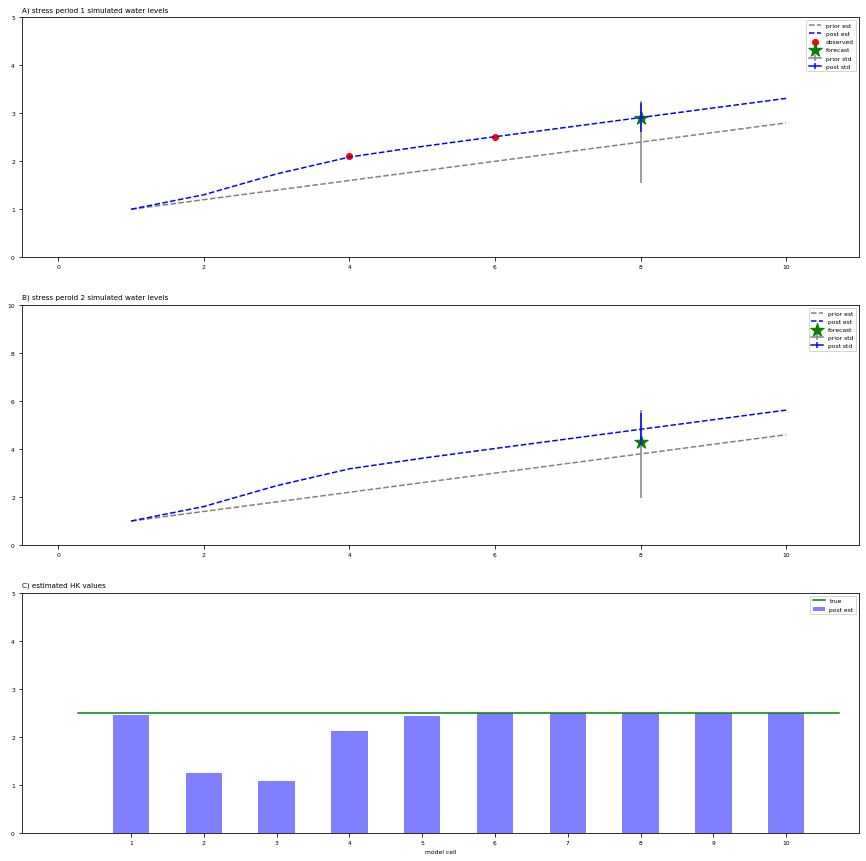

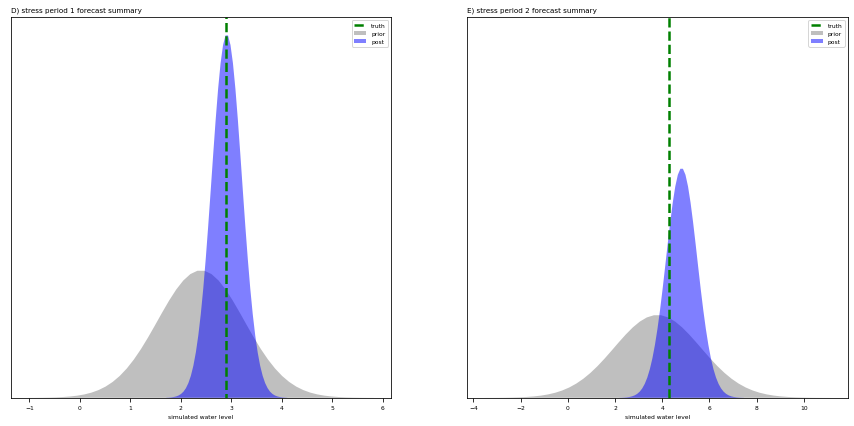

In [15]:
plot_da_attempt(pst,par_df,unc_df)

What is happening here?  We have the wrong estimated HK value in several model cells, mostly on the left side of the domain (C) but we started with the true (correct) HK values.  So the process of estimating the parameters to reproduce the historic observations has led to the wrong values!  WAT?!  That is "parameter compensation": the estimated parameter values are "compensating" for the error in the model compared to the "truth" model (e.g. "reality"). Mechanically, the estimate parameters are incorrectly be conditioned by the structural noise.  That is, the structural noise is provide "misinformation" during data assimilation.  But all is not lost! We see for the forecast in the 8th model cell under historic conditions benefits from the wrong HK values - we got that one exactly right (A and D)! How can this be?!  This is a direct result of using lots of parameters, which allowed the parameter compensation to be confined or localized to the left side of the model domain. This preserved the ability to appropriately estimate the value in the 8th cell during the first stress period. We also see the forecast in 8th cell in the second stress period is still technically "wrong" but the uncertainty posterior uncertainty estimate (vertical blue bar in B, blue distribution in E) shows that we are still covering the truth value.  Ok, Let's call this a win!

# Under parameterization

Now lets see what happens if we use only a single HK parameter for whole domain.  We will do this be tying all the HK parameters together:

In [16]:
anames = pst.adj_par_names
pst.parameter_data.loc[anames[1:],"partrans"] = "tied"
pst.parameter_data.loc[anames[1:],"partied"] = anames[0]
pst.control_data.noptmax = 3
pst.write(os.path.join(t_d,"pest_tied.pst"))

noptmax:3, npar_adj:1, nnz_obs:2


In [17]:
pyemu.os_utils.run("pestpp-glm pest_tied.pst",cwd=t_d)

In [18]:
pst = pyemu.Pst(os.path.join(t_d,"pest_tied.pst"))
pst.phi

2.925700000000002

The phi is higher than in the highly-parameterized attempt but still significantly lower than the initial phi of 50

In [19]:
pst.res.loc[pst.nnz_obs_names,:]

,name,group,measured,modelled,residual,weight
name,,,,,,
h01_04,h01_04,head,2.1,1.951,0.149,10.0
h01_06,h01_06,head,2.5,2.584,-0.084,10.0


In [20]:
par_df = pyemu.pst_utils.read_parfile(os.path.join(t_d,"pest_tied.par"))

In [21]:
unc_df = pd.read_csv(os.path.join(t_d,"pest_tied.pred.usum.csv"),index_col=0)
unc_df.iloc[[5,15],:] # the forecast rows

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
H01_08,2.4,2.56442,-2.72883,7.52883,3.218,0.127041,2.96392,3.47208
H02_08,3.8,5.18582,-6.57164,14.17160,5.436,0.256906,4.92219,5.94981


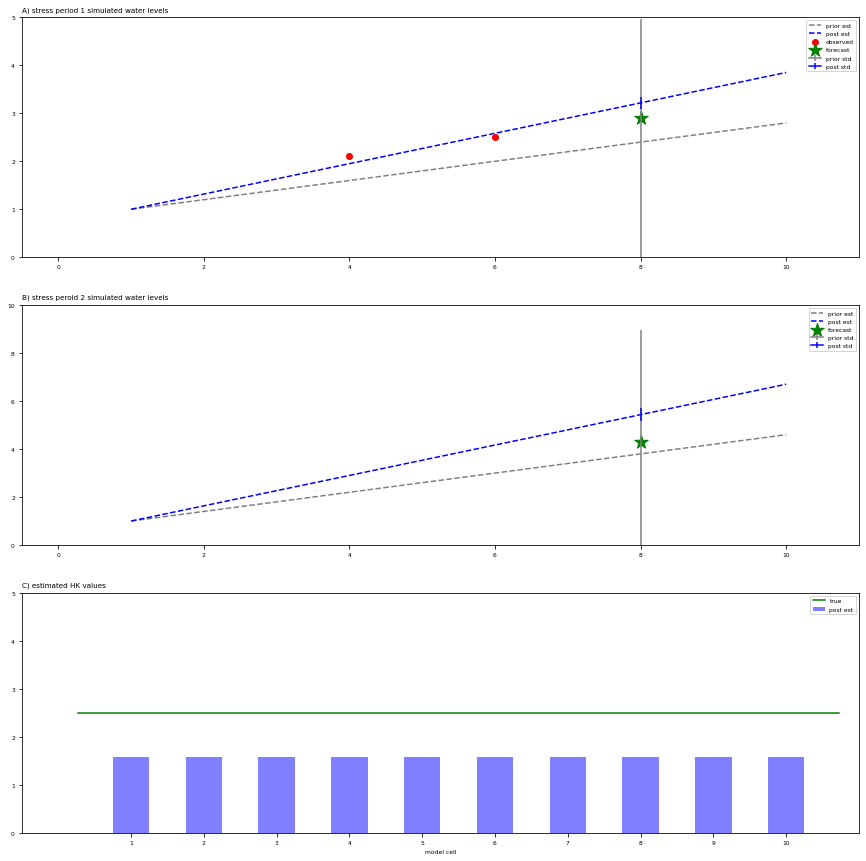

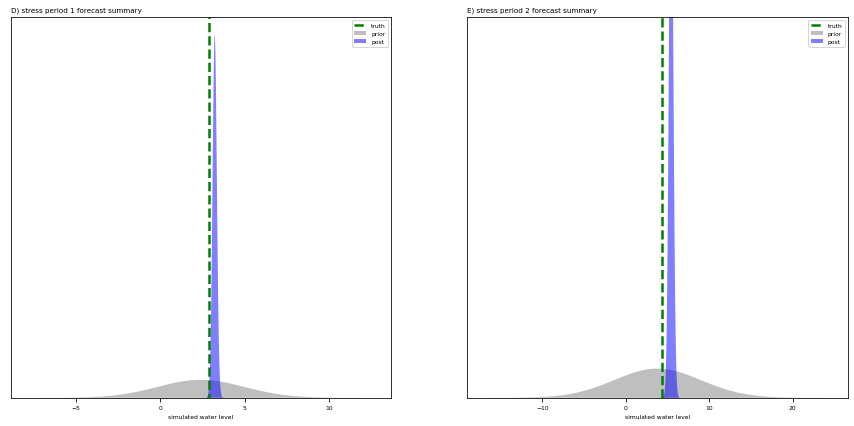

In [22]:
plot_da_attempt(pst,par_df,unc_df)

Very different results, huh?  First, the prior uncertainty (vertical grey bars on A,B and grey distributions on D,E) is much larger than in the highly-parameterized attempt.  This is an artifact of using very few parameters.  Secondly, the posterior uncertainty (vertical blue bars on A,B and blue distributions on D,E) is much smaller than in the highly-parameterized case, again an artifact of using very few parameters.  So, in essense, we are overstating the value of history matching to reduce uncertainty.  That's dangerous!

More importantly though, the posterior uncertainty estimates for both forecasts fail to cover the respective truth value - #sad! So we have biased our results through history matching and we are over confident in those biased results.  Could this get any worse?! Well, yes it could!  If you look at the second stress period forecast water level (B), you see that the prior (uncalibrated) model (grey dashed line) was closer to the truth (green star) than the calibrated result (blue dashed line) - WAT?!  That's hard to believe: history matching actually made the model a worse forecaster.  

All of these of terrible things happened because we chose to use less parameters to express model input uncertainty.  Because we only used a single HK parameter, the parameter compensation resulting from history matching in the presense of model error is now "regionalized" or spread across the model domain - every model cell now has an incorrect value.  